<a href="https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/CheckYoSelf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check Yo' Self 
**Self-serve checkout enhancement using Neural Networks and Deep Learning**

## Architecture
![alt text](https://github.com/MichaelCondo/Team9-APS360-Project/blob/main/docs/Architecture_Diagram.png?raw=true)

#### Colab Link
https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/CheckYoSelf.ipynb

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Seed for reproducible results
np.random.seed(1000)
torch.manual_seed(1000)
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## 1. Data Collection and Processing

**Tasks**:
* Understand Fruits 360 dataset
* Loading dataset into Colab
* Collecting prices of fruits
* Remove items that are not sold as individual fruits (i.e. vegetables, small berries, bunched bananas)
* Consolidate split classes either by combining or removing (e.g. Apple Red 1/2/3)
* Splitting the dataset into training, validation and testing (stratify or random) 

### 1.1 Fruits 360 Dataset

[Fruits 360](https://www.kaggle.com/moltean/fruits) is a dataset of 90000+ images of 130+ fruits and vegetables, in RGB colour at 100x100px a piece.

We're using [the GitHub mirror](https://github.com/Horea94/Fruit-Images-Dataset) to download the dataset as it does not require authentication to Kaggle.

In [2]:
# Download the dataset from GitHub
!wget -nc https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip \
    && mkdir -p "/root/project" \
    && unzip -nq "master.zip" -d "/root/project/datasets" \
    && find "/root/project/datasets/" -mindepth 2 -maxdepth 2 -type d -ls
DATA_MASTER_PATH = "/root/project/datasets/Fruit-Images-Dataset-master"

--2020-12-02 20:34:06--  https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/master [following]
--2020-12-02 20:34:06--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ] 761.30M  25.5MB/s    in 40s     

2020-12-02 20:34:47 (19.1 MB/s) - ‘master.zip’ saved [798281939]

  2243641      4 drwxr-xr-x   2 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/test-multiple_fruit

Let's take a look at the contents of the dataset. 

- How many training and testing samples do we have? 
- How many training samples are there for each of the classes?

In [3]:
!echo "Training samples" && find "{DATA_MASTER_PATH}/Training" -type f | wc -l 
!echo "Testing samples" && find "{DATA_MASTER_PATH}/Test" -type f | wc -l 
!echo "Multiple Fruits Testing samples" && find "{DATA_MASTER_PATH}/test-multiple_fruits" -type f | wc -l 

!echo "Training samples class distribution" \
    && cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

Training samples
67692
Testing samples
22688
Multiple Fruits Testing samples
103
Training samples class distribution
    984 ./Grape Blue
    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Strawberry Wedge
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    738 ./Cherry Rainier
    738 ./Cherry 2
    735 ./Walnut
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


### 1.2: Data Processing

Remove the folders that have items that are not sold individually, such as berries. Also, consolidate classes that feature the same type of fruit.

In [4]:
import requests

"""
This JSON (hosted on GitHub) contains a mapping from the original class names to
our new classes.

This will allow us to effectively consolidate classes that are similar looking
and would be treated similarly at a grocery store checkout.

We've also removed the classes that we don't want to train our model on such as
items that are not sold individually (e.g. small berries)
"""
CLASS_MAPPING = requests.get(
    "https://raw.githubusercontent.com/MichaelCondo/Team9-APS360-Project/main/mappings/original_to_new_class.json"
).json()

"""
This JSON (hosted on GitHub) contains the price per unit of our new classes.

The source is TODO

Also TODO: class prices for Quince and Salak are placeholders of -1
Also TODO: how/where to use this data?

Resources: 
* https://www.walmart.ca/en/grocery/fruits-vegetables/fruits/N-3852
* https://www.metro.ca/en/online-grocery/aisles/fruits-vegetables/fruits
* https://www.realcanadiansuperstore.ca/Food/Fruits-%26-Vegetables/c/RCSS001001000000
* https://www.fortinos.ca/Food/Fruits-%26-Vegetables/c/FTN001001000000 
* https://www.loblaws.ca/Food/Fruits-%26-Vegetables/c/LSL001001000000 
"""
CLASS_PRICES = requests.get(
    "https://raw.githubusercontent.com/MichaelCondo/Team9-APS360-Project/main/mappings/class_to_price.json"
).json()

In [5]:
CLASS_PRICES

{'Apple Braeburn': 0.72,
 'Apple Crimson Snow': 0.92,
 'Apple Golden': 0.99,
 'Apple Granny Smith': 0.81,
 'Apple Pink Lady': 0.92,
 'Apple Red': 0.87,
 'Apple Red Delicious': 0.79,
 'Apple Red Yellow': 0.78,
 'Apricot': 0.99,
 'Avocado': 1.67,
 'Beetroot': 0.66,
 'Cactus fruit': 1.99,
 'Cantaloupe': 2.97,
 'Carambula': 0.85,
 'Cauliflower': 2.98,
 'Clementine': 0.92,
 'Cocos': 2.49,
 'Corn': 0.86,
 'Corn Husk': 1.99,
 'Cucumber Ripe': 1.48,
 'Dates': 0.66,
 'Eggplant': 3.74,
 'Fig': 1.33,
 'Ginger Root': 2.47,
 'Granadilla': 1.98,
 'Grapefruit Pink': 1.97,
 'Grapefruit White': 1.98,
 'Guava': 0.69,
 'Kaki': 0.68,
 'Kiwi': 0.77,
 'Kohlrabi': 3.29,
 'Kumquats': 0.65,
 'Lemon': 0.67,
 'Lemon Meyer': 0.67,
 'Limes': 0.37,
 'Lychee': 0.98,
 'Mandarine': 0.58,
 'Mango': 1.47,
 'Mango Red': 1.47,
 'Mangostan': 2.5,
 'Maracuja': 1.99,
 'Melon Piel de Sapo': 6.16,
 'Nectarine': 0.59,
 'Nectarine Flat': 0.59,
 'Onion Red': 1.62,
 'Onion White': 0.98,
 'Orange': 1.04,
 'Papaya': 3.94,
 'Passion 

In [6]:
import os
import shutil

for dataset_type in ["Training", "Test", "test-multiple_fruits"]:
    for f in os.scandir(f"{DATA_MASTER_PATH}/{dataset_type}"):
        if f.is_dir() and f.name not in CLASS_MAPPING:
            shutil.rmtree(f.path)
            print("Removed", dataset_type, "/", f.name)

Removed Training / Nut Pecan
Removed Training / Strawberry Wedge
Removed Training / Cherry 1
Removed Training / Cherry 2
Removed Training / Redcurrant
Removed Training / Blueberry
Removed Training / Huckleberry
Removed Training / Cherry Rainier
Removed Training / Cherry Wax Black
Removed Training / Grape Blue
Removed Training / Banana Lady Finger
Removed Training / Strawberry
Removed Training / Grape White 4
Removed Training / Grape Pink
Removed Training / Raspberry
Removed Training / Banana
Removed Training / Chestnut
Removed Training / Walnut
Removed Training / Nut Forest
Removed Training / Cherry Wax Red
Removed Training / Cherry Wax Yellow
Removed Training / Grape White
Removed Training / Grape White 3
Removed Training / Mulberry
Removed Training / Hazelnut
Removed Training / Banana Red
Removed Training / Grape White 2
Removed Test / Nut Pecan
Removed Test / Strawberry Wedge
Removed Test / Cherry 1
Removed Test / Cherry 2
Removed Test / Redcurrant
Removed Test / Blueberry
Removed T

In [7]:
!cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    711 ./Pear Stone
    702 ./Pepper Orange
    702 ./Pear Forelle
    702 ./Fig
    702 ./Cauliflower
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


### 1.3: Data loading

Now we'll create Pytorch dataloaders for our train, validation, and test sets

In [8]:
class Augment(object):
    """Augment image by modifying background colour to something random."""

    def __call__(self, pic):
        img = pic.convert("RGB")
        datas = img.getdata()
        
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        newData = []
        for item in datas:
            if item[0] >= 240 and item[1] >= 240 and item[2] >= 240:
                newData.append(color)
            else:
                newData.append(item)

        img.putdata(newData)
        return img

In [9]:
class Brightness(object):
    """Augment image by modifying background colour to something random."""

    def __call__(self, pic):
        return transforms.functional.adjust_brightness(pic, brightness_factor=1.1)

In [10]:
class Contrast(object):
    """Augment image by modifying background colour to something random."""

    def __call__(self, pic):
        return transforms.functional.adjust_contrast(pic, contrast_factor=1.5)

In [11]:
class RemappedImageFolder(torchvision.datasets.ImageFolder):
    """Subclass of ImageFolder that lets you remap your classes at parse time
    instead of through target_transform (which would be applied on every getitem)
    """

    def __init__(self, class_remapping, **kwargs):
        self.class_remapping = class_remapping
        super(RemappedImageFolder, self).__init__(**kwargs)

    def _find_classes(self, dir):
        """Override ImageFolder's class identification method so we can
        do custom consolidation of our classes.
        See https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
        """
        # Get the original classes (i.e. folder names)
        o_classes = super()._find_classes(dir)[0]

        # Get our classes (from the JSON mapping)
        classes = list(sorted(set(self.class_remapping.values())))

        # Create an index for only our new classes
        new_class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Map the old classes to their indices in our new system
        real_class_to_idx = {
            old_class: new_class_to_idx[self.class_remapping[old_class]]
            for old_class in o_classes
        }

        return classes, real_class_to_idx

In [12]:
from sklearn.model_selection import train_test_split

def get_data_loaders(batch_size=1, num_workers=1):
    """Loads images of produce, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch (<1 means 
        use the full dataset in every batch)
    
    Returns:
        train_loader: iterable training dataset (from training data)
        val_loader: iterable validation dataset (from training data)
        test_loader: iterable testing dataset (from test data)
        classes: A list of strings denoting the name of each class
    """
    ########################################################################
    # We'll return a (train, val, test, classes) tuple
    classes = list(sorted(set(CLASS_MAPPING.values())))

    # Load datasets
    train_set = RemappedImageFolder(class_remapping=CLASS_MAPPING,
            root=f"{DATA_MASTER_PATH}/Training",
            transform=transforms.Compose(
                [transforms.RandomApply([transforms.RandomCrop(80), Brightness(), Contrast()], p=0.80),
                 transforms.Resize((100, 100)),
                 transforms.ToTensor()]
            ),
        )

    test_set = RemappedImageFolder(class_remapping=CLASS_MAPPING,
            root=f"{DATA_MASTER_PATH}/Test",
            transform=transforms.Compose(
                [transforms.Resize((100, 100)), 
                 transforms.ToTensor()]
            ),
        )

    # Split train/validation data with stratification of classes
    train_idx, val_idx = train_test_split(
        np.arange(len(train_set.targets)),
        test_size=0.3,
        shuffle=True,
        stratify=train_set.targets
    )

    train_set, val_set = [
        torch.utils.data.Subset(train_set, idx)
        for idx in [train_idx, val_idx]
    ]

    # Create and return the data loaders
    bs = len(train_set) if batch_size < 1 else batch_size
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )
    
    bs = len(val_set) if batch_size < 1 else batch_size
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )
    
    bs = len(test_set) if batch_size < 1 else batch_size
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )

    return train_loader, val_loader, test_loader, classes

Found 37034 Training examples
Found 15872 Validation examples
Found 17731 Test examples
There are 88 classes
Training set looks like:


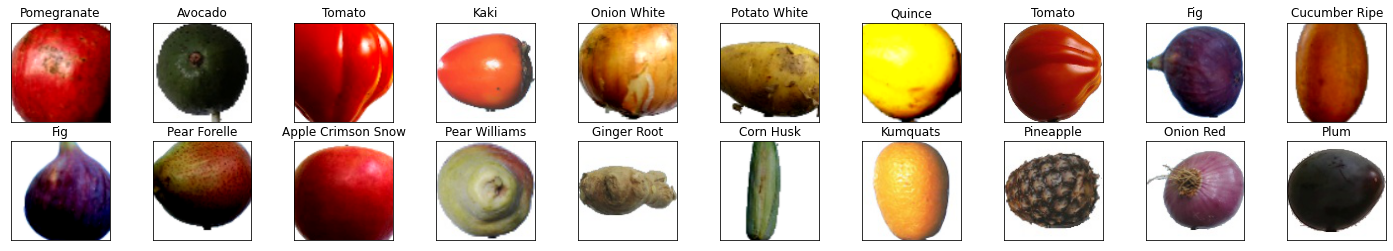

In [13]:
# Count the samples
for kind, loader in zip(["Training", "Validation", "Test"], get_data_loaders()[:3]):
    print(f"Found {len(loader)} {kind} examples")

# Prepare dataloaders for real
train_loader, val_loader, test_loader, classes = get_data_loaders(
    batch_size=27  # we know that this is a divisor of the number of submissions
)

print("There are", len(classes), "classes")

print("Training set looks like:")
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## 2. Baseline Model

**Tasks**:
* Setup and train random forrest model


In [ ]:
train_images = []
train_labels = []
for inputs, labels in iter(train_loader):
  for image in inputs:
    #Resize image from (100, 100) to (45, 45)
    image = image.unsqueeze(0)
    image = torch.nn.functional.interpolate(image,size=(45,45), mode='bilinear')
    image = image.squeeze(0)

    #Transform Tensor from [3, 45, 45] to a numpy array of shape (45, 45, 3)
    image = image.permute(1, 2, 0).numpy()
    train_images.append(image)

  for label in labels:
    train_labels.append(label)

print(len(train_images))
print(len(train_labels))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


38035
38035


In [ ]:
print(train_images[0].shape)

(45, 45, 3)


In [ ]:
test_images = []
test_labels = []
for inputs, labels in iter(get_data_loaders(-1)[2]):
  for image in inputs:
    #Resize image from (100, 100) to (45, 45)
    image = image.unsqueeze(0)
    image = torch.nn.functional.interpolate(image,size=(45,45), mode='bilinear')
    image = image.squeeze(0)

    #Transform Tensor from [3, 45, 45] to a numpy array of shape (45, 45, 3)
    image = image.permute(1, 2, 0).numpy()
    test_images.append(image)

  for label in labels:
    test_labels.append(label)
    
print(len(test_images))
print(len(test_labels))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


18215
18215


In [ ]:
print(test_images[0].shape)
print(test_labels[0])

(45, 45, 3)
tensor(89)


In [ ]:
train_images = np.array(train_images)
print(train_images.shape)

# 38035 is the number of samples, 6075 is 45*45*3
train_pixels = train_images.flatten().reshape(38035, 6075)
print(train_pixels.shape)

train_labels = np.array(train_labels)
print(train_labels.shape)

(38035, 45, 45, 3)
(38035, 6075)
(38035,)


In [ ]:
test_images = np.array(test_images)
print(test_images.shape)

# 18215 is the number of samples, 6075 is 45*45*3
test_pixels = test_images.flatten().reshape(18215, 6075)
print(test_pixels.shape)

test_labels = np.array(test_labels)
print(test_labels.shape)

(18215, 45, 45, 3)
(18215, 6075)
(18215,)


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=250)

# Fit the model to our training data
model.fit(train_pixels, train_labels)

#Make predictions
testing_predicted = model.predict(test_pixels)

In [ ]:
correct = 0
for i in range(len(testing_predicted)):
  if testing_predicted[i] == test_labels[i]:
    correct += 1

score = 100* (correct / len(testing_predicted))

print("RF Test:", score)

RF Test: 94.3178698874554


## 3. Model Setup

**Tasks**:
* Using previous labs as reference, create CNN skeleton to work for 100x100 RGB images


In [14]:
class CNN(nn.Module):
    """
    A simple CNN classifier that takes a list of output classes on init
    to determine the output layer size. Assumes an input of size nx3x100x100.
    """
    def __init__(self, output_classes):
        super(CNN, self).__init__()
        num_outputs = len(output_classes)
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 2, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 250),
            nn.ReLU(),
            nn.Linear(250, num_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.classifier(x)
        return x

In [15]:
model = CNN(classes)
# See if dimensions are okay
model(torch.randn((64, 3, 100, 100)))

# See model stats
print(model.__class__.__name__, "parameters:", sum(p.numel() for p in model.parameters()))
print(model)

CNN parameters: 288882
CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=88, bias=True)
  )
)


## 4. Model Training and Tuning

**Tasks**:
* Write training code 
* Adjust hyperparameters to get at least 90% validation accuracy
* Evaluate model on the test set to see true performance



In [16]:
def get_model_name(model, batch_size=1, learning_rate=1e-3, iteration=0):
    """Generate a name for the model with the hyperparameter values"""
    return "model_{0}_bs{1}_lr{2}_checkpoint{3}".format(
        model.__class__.__name__, batch_size, learning_rate, iteration
    )


def evaluate(model, data_loader, criterion=None):
    """Evaluate the model (accuracy, loss) on the given dataset
    If critierion is not provided, only accuracy will be computed.
    """
    correct, total = 0, 0
    total_loss = 0.0
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Calculate batch
        outputs = model(inputs)

        # Correctness: select index with maximum prediction score
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += pred.shape[0]

        # Optional loss computation
        if criterion:
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    if criterion:
        return correct / total, total_loss / len(data_loader)
    else:
        return correct / total


def plot_training_curve(path):
    """ Plots accuracy/loss curves for a model run given the CSV path"""
    import matplotlib.pyplot as plt

    iterations, train_acc, val_acc, train_loss, val_loss = np.loadtxt(
        f"{model_path}_training.csv"
    ).T

    plt.title("Train vs Validation Accuracy")
    plt.plot(iterations, train_acc, label="Train")
    plt.plot(iterations, val_acc, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(iterations, train_loss, label="Train")
    plt.plot(iterations, val_loss, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    print(
        "Best Training Accuracy: {:.2f}% @ checkpoint {:.0f}".format(
            max(train_acc) * 100, iterations[np.argmax(train_acc)]
        )
    )
    print(
        "Best Validation Accuracy: {:.2f}% @ checkpoint {:.0f}".format(
            max(val_acc) * 100, iterations[np.argmax(val_acc)]
        )
    )

In [17]:
def train(model, batch_size=1, num_epochs=1, learning_rate=1e-3, plot_frequency=1):
    train_loader, val_loader, test_loader, classes = get_data_loaders(
        batch_size=batch_size
    )

    # Statistic collection
    PLOT_ITERATIONS = int(-(-len(train_loader) // plot_frequency))  # ceil division
    iterations, train_acc, val_acc, train_loss, val_loss = [], [], [], [], []

    def collect_stats(epoch, iteration, t_loss=None):
        # Don't double count
        if iterations and iterations[-1] >= iteration:
            return
        # Compute and store
        if t_loss is None:
            t_acc, t_loss = evaluate(model, train_loader, criterion)
        else:
            t_acc = evaluate(model, train_loader)

        v_acc, v_loss = evaluate(model, val_loader, criterion)

        iterations.append(iteration)
        train_acc.append(t_acc)
        val_acc.append(v_acc)
        train_loss.append(t_loss)
        val_loss.append(v_loss)

        # Checkpoint model
        model_path = get_model_name(model, batch_size, learning_rate, iteration)
        torch.save(model.state_dict(), model_path)

        # Print stats
        print(
            f"@{time.time()-start_time : .2f}s",
            f"Epoch {epoch} Iteration {iteration}:",
            f"Train acc: {t_acc * 100 : .2f}%",
            f"Train loss: {t_loss : .4f}",
            "|",
            f"Validation acc: {v_acc * 100 : .2f}%",
            f"Validation loss: {v_loss : .4f}",
        )

    # Training loop
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the network
    print("Training Started...")
    start_time = time.time()
    iteration = 0
    for epoch in range(num_epochs):
        for inputs, labels in iter(train_loader):
            # Place on correct device if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass, backward pass, optimize, and clean up
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Compute training metrics
            iteration += 1
            if iteration % PLOT_ITERATIONS == 0:
                collect_stats(epoch, iteration, loss.item())

    # Final stats (runs only if previous iteration wasn't saved)
    collect_stats(epoch, iteration, loss.item())

    print(f"Finished Training -- Total time elapsed: {time.time()-start_time : .2f}s")
    model_path = get_model_name(model, batch_size, learning_rate, iteration)
    np.savetxt(
        f"{model_path}_training.csv",
        np.c_[iterations, train_acc, val_acc, train_loss, val_loss],
    )
    return model_path

In [36]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/APS360 Project/model_checkpoint'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1sOVGWbjVyiw8CNTzkyz6ToYLdCY6uTjl/APS360 Project/model_checkpoint


Training Started...
@ 107.88s Epoch 0 Iteration 1372: Train acc:  82.43% Train loss:  0.5698 | Validation acc:  81.99% Validation loss:  0.5157
@ 215.81s Epoch 1 Iteration 2744: Train acc:  86.54% Train loss:  0.1185 | Validation acc:  86.20% Validation loss:  0.4065
@ 323.88s Epoch 2 Iteration 4116: Train acc:  94.92% Train loss:  0.1166 | Validation acc:  94.68% Validation loss:  0.1554
@ 432.44s Epoch 3 Iteration 5488: Train acc:  94.51% Train loss:  0.4249 | Validation acc:  94.56% Validation loss:  0.1665
@ 539.75s Epoch 4 Iteration 6860: Train acc:  96.20% Train loss:  0.0453 | Validation acc:  95.94% Validation loss:  0.1109
@ 647.81s Epoch 5 Iteration 8232: Train acc:  95.96% Train loss:  0.0718 | Validation acc:  95.75% Validation loss:  0.1120
@ 755.79s Epoch 6 Iteration 9604: Train acc:  96.45% Train loss:  0.0791 | Validation acc:  96.63% Validation loss:  0.1217
@ 863.55s Epoch 7 Iteration 10976: Train acc:  98.46% Train loss:  0.0617 | Validation acc:  98.56% Validation l

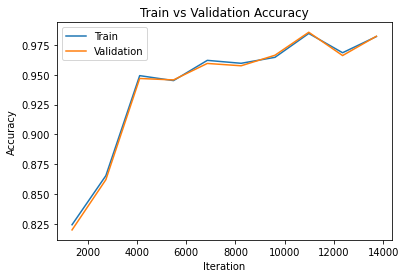

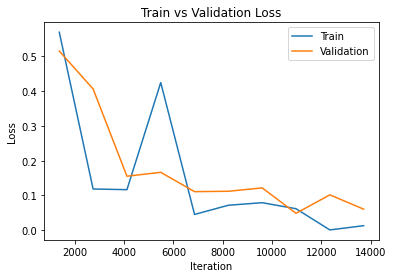

Best Training Accuracy: 98.46% @ checkpoint 10976
Best Validation Accuracy: 98.56% @ checkpoint 10976


In [37]:
model = CNN(classes)
if torch.cuda.is_available():
    model.cuda()

model_path = train(
    model,
    batch_size=27,
    num_epochs=10,
    learning_rate=1e-3,
    plot_frequency=1,
)
print("Model available at:", model_path)
plot_training_curve(model_path)

In [19]:
model = CNN(classes)

model.load_state_dict(torch.load(get_model_name(model, 27, 1e-3, 13720)))
if torch.cuda.is_available():
    model.cuda()

test_acc = evaluate(model, get_data_loaders(-1)[2])
print("Testing Accuracy: {:.2f}%".format(test_acc * 100))

Testing Accuracy: 92.34%


Test set verification:


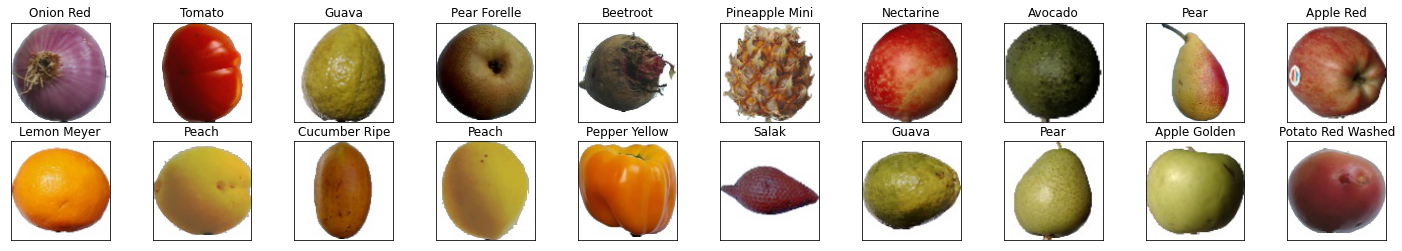

In [20]:
print("Test set verification:")

# Obtain one batch of test images
dataiter = iter(get_data_loaders(-1, 0)[2])
images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# for image in images:
#   print(type(image))
#   break
out = model(images.cuda())
pred = out.max(1, keepdim=True)[1]
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[pred[idx]])

In [ ]:
"""
  Here we can visually verify a batch of images from the test set classified 
  by the model
"""

# 5. Object Localization and Classification


### Object Detection

In [21]:
import torchvision
import cv2
from PIL import Image
from torchvision.transforms import ToTensor
from matplotlib import cm
!pip install ffmpy

In [22]:
model_restNet = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_restNet.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [23]:
# Give an image and get the bounding boxes 
def get_prediction(img_path, threshold, open=False):
  if open:
    img = Image.open(img_path) # Load the image
  else:
    img = img_path
  transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model_restNet([img]) # Pass the image to the model
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold] # Get list of index with score greater than threshold.

  if len(pred_t) > 0:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    return pred_boxes
  else:
    pred_t = 0
    return []
  

# Crop each image with the bounding boxes 
def seg_img (img_path, boxes, plot=False, open=False):
  img_list = []
  for i in range(len(boxes)):
    if open:
      im = Image.open(img_path) 
    else:
      im = img_path
      im = Image.fromarray(np.uint8(im)).convert('RGB')  #convert numpy array to PIL image
    im = im.crop((boxes[i][0][0], boxes[i][0][1], boxes[i][1][0], boxes[i][1][1]))
    img_list.append(im)
    if plot:
      plt.imshow(im)
      plt.show()
  return img_list

# ref: https://stackoverflow.com/questions/44231209/resize-rectangular-image-to-square-keeping-ratio-and-fill-background-with-black/44231784
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def classify_cropped_images(seg_img_list, plot=False):
  images = []
  for im in seg_img_list:
    im = make_square(im, fill_color=(255, 255, 255, 0))
    im = im.resize((100, 100)) # #Resize Image to 100, 100
    im = ToTensor()(im) # #convert PIL image to tensor
    images.append(im)

  images = torch.stack(images)
  model = CNN(classes)
  model.load_state_dict(torch.load(get_model_name(model, 27, 1e-3, 13720)))

  if torch.cuda.is_available():
      model.cuda()
  out = model(images.cuda())
  pred = out.max(1, keepdim=True)[1]
  images = images.numpy()               # convert images to numpy for display

  # plot the images in the batch, along with the corresponding labels
  if plot:
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(len(pred)):
        ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[pred[idx]])
  
  predictionClasses = []
  for p in pred:
    predictionClasses.append(classes[p])
  return predictionClasses

def object_detection_api(img_path, open=False, plot=False, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  boxes = get_prediction(img_path, threshold, open) # Get predictions
  pred_cls = []

  if len(boxes) > 0:
    seg_img_list = seg_img(img_path, boxes, plot, open)
    pred_cls = classify_cropped_images(seg_img_list, plot)

  new_boxes = []
  for box in boxes:
    new_box = [box[0][0], box[0][1], box[1][0], box[1][1]]
    new_boxes.append(new_box)

  return new_boxes, pred_cls

In [ ]:
%cd '/content/drive/MyDrive/APS360 Project/model_checkpoint'
boxes, pred_cls = object_detection_api('/root/project/datasets/Fruit-Images-Dataset-master/test-multiple_fruits/apple_pear.jpg', open=True, plot=False, threshold=0.5)

### Receipt Creation

In [25]:
def create_receipt(pred_cls):
  """
    cust_cart = {'apple': ['count', 'price']}
  """
  cust_cart = {}
  for pred in pred_cls:
    if pred in cust_cart:
      cust_cart[pred][0] += 1
    else:
      cust_cart[pred] = []
      cust_cart[pred].append(1) 
      cust_cart[pred].append(CLASS_PRICES[pred]) 
  return cust_cart

In [26]:
cart = create_receipt(pred_cls)
subtotal = 0
for fruit, info in cart.items():
  price = round(info[0] * info[1], 2)
  print(fruit + ": " + str(info[0]))
  print("\t" + str(info[0]) + " x " + str(price) + "\t$" + str(price))
  subtotal += price

subtotal = round(subtotal, 2)
print("\nSubtotal: $" + str(subtotal))

tax = 1.13
total = round(subtotal * tax, 2)
print("Total: $" + str(total))

Pomegranate: 9
	9 x 11.43	$11.43
Nectarine: 2
	2 x 1.18	$1.18
Tomato Heart: 1
	1 x 1.16	$1.16
Cucumber Ripe: 2
	2 x 2.96	$2.96
Apple Red: 1
	1 x 0.87	$0.87
Apple Crimson Snow: 1
	1 x 0.92	$0.92
Apple Red Delicious: 1
	1 x 0.79	$0.79
Tomato Maroon: 1
	1 x 0.78	$0.78
Cactus fruit: 2
	2 x 3.98	$3.98

Subtotal: $24.07
Total: $27.2


# 6. Detecting Objects in Videos

### Detect fruits in video and draw bounding boxes with classification 

In [27]:
classes = list(sorted(set(CLASS_MAPPING.values())))
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

In [79]:
def draw_boxes(boxes, preds, image):
    # read the image with OpenCV
    for i, box in enumerate(boxes):
        pred_idx = classes.index(preds[i])
        color = COLORS[pred_idx]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 4
        )
        cv2.putText(image, preds[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 0), 1, 
                    lineType=cv2.LINE_AA)
    return image

In [76]:
import cv2
import numpy as np

## remove previous files to avoid overlap
%cd '/content/drive/MyDrive/APS360 Project/output'
!rm -r output.avi
!rm -r output.mp4
!ls 

# reset directory to model checkpoints
%cd '/content/drive/MyDrive/APS360 Project/model_checkpoint'

# All the test video
test_vids_paths = [ '/content/drive/MyDrive/APS360 Project/fruit_video_Trim.mp4',
                    '/content/drive/MyDrive/APS360 Project/Fruit_Vid_001.mp4'          
                  ]

# Set path for your test vid
vid_path = test_vids_paths[1]

# Create a VideoCapture object
cap = cv2.VideoCapture(vid_path)

# Check if camera opened successfully
if (cap.isOpened() == False): 
  print("Unable to read camera feed")

# Create VideoWriter object and write to output file "output.avi"
out_dim_x = 1280
out_dim_y = 720
out = cv2.VideoWriter('/content/drive/MyDrive/APS360 Project/output/output.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (out_dim_x, out_dim_y))

# Number of frames in the video
print(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

while(cap.isOpened()):
  ret, frame = cap.read()

  if ret == True: 
    with torch.no_grad():
        frame = cv2.resize(frame, (out_dim_x, out_dim_y))
        boxes, preds = object_detection_api(frame)
        
    # Draw boxes around dtected objects in current frame
    if len(boxes) > 0:
      image = draw_boxes(boxes, preds, frame)
      out.write(image)  # Write the frame into the file 'output.avi'

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Break the loop
  else:
    break  

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows() 

/content/drive/.shortcut-targets-by-id/1sOVGWbjVyiw8CNTzkyz6ToYLdCY6uTjl/APS360 Project/output
/content/drive/.shortcut-targets-by-id/1sOVGWbjVyiw8CNTzkyz6ToYLdCY6uTjl/APS360 Project/model_checkpoint
89


In [77]:
import ffmpy

ff = ffmpy.FFmpeg(
    inputs={'/content/drive/MyDrive/APS360 Project/output/output.avi':None},
    outputs={'/content/drive/MyDrive/APS360 Project/output/output.mp4': None}
)

ff.run()

(None, None)

In [78]:
from IPython.display import HTML
from base64 import b64encode

video_path = "/content/drive/MyDrive/APS360 Project/output/output.mp4"

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=800 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
""")

### Create videos using fruits 360 dataset images 

In [ ]:
import cv2
import os

def get_image_index(filename):
    """
    Images are named like index_100.jpg or r{x}_index_100.jpg, so we need to 
    get them in a comparable value for sorting
    """
    key = filename.rsplit("_", maxsplit=1)[0]
    if key.startswith("r"):
        r_id, r_idx = key[1:].split("_", maxsplit=1)
        r_id = r_id or "1" # r, r2, r3; r->r1
        return int(r_id) * 1000 + int(r_idx)
    else:
        return int(key)


# Collect frames for the video
fruit_images = {}
base_folder = f"{DATA_MASTER_PATH}/Test/"
for fruit in list(sorted(os.listdir(base_folder)))[:1]:
    image_folder = f"{base_folder}/{fruit}"
    f_images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    f_images.sort(key=get_image_index)
    fruit_images[image_folder] = f_images

# Join the frames and output to a file
video_name = "/content/sample.mp4"
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 120, (100,100))

for folder, images in fruit_images.items():
    for image in images:
        video.write(cv2.imread(os.path.join(folder, image)))

video.release()